# Semantic ID Tutorial: Text Clustering with AG News

Welcome to this tutorial on **Semantic ID**! 

In this notebook, we will demonstrate how to generate semantic identifiers for a textual dataset (AG News). We will cover:

1.  **RQ-KMeans**: Hierarchical clustering on CPU, GPU, and MPS.
2.  **Token Format**: LLM-friendly ID output.
3.  **Evaluation**: Built-in quality metrics.
4.  **Reconstruction**: Decoding codes back to approximate vectors.
5.  **Balanced Clustering**: Constrained K-Means for even code distribution.
6.  **Uniqueness**: Handling ID collisions automatically.
7.  **RQ-VAE**: Using neural networks for quantization.
8.  **Training History**: Monitoring RQ-VAE training progress.
9.  **SinkhornResolver**: Semantically-aware collision resolution.
10. **Save / Load**: Persisting models and engines.

## Prerequisites

First, let's install the required libraries.

In [1]:
# !pip install semantic-id datasets sentence-transformers pandas

## Imports and Setup

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from sentence_transformers import SentenceTransformer

# Semantic ID imports (top-level package exports everything you need)
from semantic_id import (
    RQKMeans,
    RQVAE,
    SemanticIdEngine,
    UniqueIdResolver,
    SinkhornResolver,
    InMemoryCollisionStore,
    SQLiteCollisionStore,
    evaluate,
)

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

/Users/mikhail/VSCodeProjects/semantic-id/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Data and Generate Embeddings

We will use the **AG News** dataset, which contains news articles categorized into World, Sports, Business, and Sci/Tech. This is a perfect dataset to see if our IDs capture semantic meaning (e.g., all Sports articles should have similar IDs).

In [3]:
# Load dataset
print("Loading AG News dataset...")
dataset = load_dataset("ag_news", split="train")

# Subsample for this tutorial (20,000 samples)
# This keeps the execution fast while providing enough data for clustering.
subset_size = 20000
dataset = dataset.shuffle(seed=42).select(range(subset_size))

texts = dataset["text"]
labels = dataset["label"]
label_names = dataset.features["label"].names

print(f"Loaded {len(texts)} samples.")
print(f"Example category: {label_names[labels[0]]}")
print(f"Example text: {texts[0][:100]}...")

Loading AG News dataset...


Loaded 20000 samples.
Example category: World
Example text: Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Banglades...


Now we generate vector embeddings for our text. We use `all-MiniLM-L6-v2` from SentenceTransformers, which is fast and efficient.

In [4]:
model_name = 'all-MiniLM-L6-v2'
embedding_model = SentenceTransformer(model_name)

print(f"Generating embeddings using {model_name}...")
embeddings = embedding_model.encode(texts, show_progress_bar=True)

print(f"Embeddings shape: {embeddings.shape}")

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 2049.67it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Generating embeddings using all-MiniLM-L6-v2...


Batches: 100%|██████████| 625/625 [00:20<00:00, 30.03it/s]


Embeddings shape: (20000, 384)


## 2. RQ-KMeans (Residual Quantization K-Means)

This algorithm hierarchically clusters the data. 
- **Level 1**: Coarse clustering (e.g., broad topics)
- **Level 2**: Fine clustering (sub-topics)
- **Level 3+**: Even finer detail

We will use **4 levels** with **10 clusters** each. This gives us a theoretical capacity of $10^4 = 10,000$ unique buckets. Since we have 20,000 items, we *will* have collisions, which we'll handle later.

In [5]:
# Detect available device
if torch.cuda.is_available():
    device = "cuda"
    print("Using GPU (CUDA) 🚀")
elif torch.backends.mps.is_available():
    device = "mps"
    print("Using Mac MPS 🍎")
else:
    device = "cpu"
    print("Using CPU 🐢")

# Initialize RQ-KMeans
rq_kmeans = RQKMeans(
    n_levels=4, 
    n_clusters=10, 
    random_state=42,
    verbose=True
)

# Fit the model
print("Training RQ-KMeans...")
rq_kmeans.fit(embeddings, device=device)

Using Mac MPS 🍎
Training RQ-KMeans...


RQ-KMeans fit (mps): 100%|██████████| 4/4 [00:13<00:00,  3.29s/level]


### Generate Semantic IDs
Now let's see what the IDs look like!

In [6]:
codes = rq_kmeans.encode(embeddings, device=device)
sids = rq_kmeans.semantic_id(codes)

# Create a DataFrame to analyze
df = pd.DataFrame({
    "text": texts,
    "label": [label_names[l] for l in labels],
    "semantic_id": sids
})

print(df.head(10))

                                                text     label semantic_id
0  Bangladesh paralysed by strikes Opposition act...     World     6-5-4-4
1  Desiring Stability Redskins coach Joe Gibbs ex...    Sports     3-0-7-4
2  Will Putin #39;s Power Play Make Russia Safer?...     World     2-1-2-4
3  U2 pitches for Apple New iTunes ads airing dur...  Sci/Tech     3-8-4-7
4  S African TV in beheading blunder Public broad...     World     0-1-9-2
5  A Cosmic Storm: When Galaxy Clusters Collide A...  Sci/Tech     4-5-3-8
6  West sets deadline for Iran to freeze uranium ...     World     2-9-0-7
7  Computer Assoc. Cuts 800 Jobs Worldwide (AP) A...  Sci/Tech     9-2-5-1
8  CA Opens Utility Pricing for Mainframes Keepin...  Sci/Tech     9-1-7-5
9  Economy builds steam in KC Fed district The ec...  Business     7-1-7-8


### LLM-Friendly Token Format

When feeding semantic IDs into a language model, you can use the `token` format which wraps each level in angle brackets with a level letter. This avoids tokenization issues with plain separators.

In [7]:
# Standard plain format (default)
plain_ids = rq_kmeans.semantic_id(codes)
print(f"Plain format:  {plain_ids[:5]}")

# Token format for language models
token_ids = rq_kmeans.semantic_id(codes, fmt="token")
print(f"Token format:  {token_ids[:5]}")

# You can also customize the separator in plain mode
slash_ids = rq_kmeans.semantic_id(codes, sep="/")
print(f"Slash format:  {slash_ids[:5]}")

Plain format:  ['6-5-4-4', '3-0-7-4', '2-1-2-4', '3-8-4-7', '0-1-9-2']
Token format:  ['<a_6><b_5><c_4><d_4>', '<a_3><b_0><c_7><d_4>', '<a_2><b_1><c_2><d_4>', '<a_3><b_8><c_4><d_7>', '<a_0><b_1><c_9><d_2>']
Slash format:  ['6/5/4/4', '3/0/7/4', '2/1/2/4', '3/8/4/7', '0/1/9/2']


### Inspect Clustering Quality
Let's sort by `semantic_id` to see if similar articles are grouped together.

In [8]:
df_sorted = df.sort_values("semantic_id")
print(df_sorted[["semantic_id", "label", "text"]].head(20))

      semantic_id   label                                               text
6552      0-0-0-2   World  Reporters Put Under Scrutiny in C.I.A. Leak Th...
7322      0-0-0-2   World  Navy secretary assures torture allegations by ...
8066      0-0-0-2   World  Bush Frees Secret Service Agent from Chile Gua...
16697     0-0-0-2   World  Suspect held at  #39;mini-Guantanamo #39; for ...
14871     0-0-0-6   World  Whistleblower  #39;under house arrest #39; FOR...
1908      0-0-0-7  Sports  Kenteris protests innocence Greek sprinter Kos...
14495     0-0-1-0   World  Pitcairn men linked with  #39;a culture of sex...
18754     0-0-1-0   World  Former England star Gazza hit by pneumonia (AF...
6671      0-0-1-2   World  Army Official Backs Ex-Abu Ghraib Officer The ...
7231      0-0-1-2   World  UK Hostage Bigley #39;s Killing Confirmed by H...
939       0-0-1-3   World  Killing of Hostage Confounds Self-Image of Ita...
9736      0-0-1-4   World  World mourns murder of Hassan Australia joined...

### Evaluate ID Quality

The `evaluate()` function measures how well the semantic IDs preserve the structure of the original embeddings. Key metrics:

| Metric | Meaning |
|---|---|
| `collision_rate` | Fraction of items that share a code with another item (lower is better) |
| `recall_at_10` | How well code-space neighbors match embedding-space neighbors (higher is better) |
| `distance_correlation` | Spearman correlation between embedding distances and code Hierarchical distances (higher is better) |
| `quantization_mse` | Reconstruction error when decoding codes back to vectors (lower is better) |

In [9]:
# Evaluate RQ-KMeans quality (pass encoder to also get quantization_mse)
kmeans_metrics = evaluate(embeddings, codes, encoder=rq_kmeans)

print("RQ-KMeans Quality Metrics:")
print("-" * 40)
for key, value in kmeans_metrics.items():
    if isinstance(value, float):
        print(f"  {key:>25s}: {value:.4f}")
    else:
        print(f"  {key:>25s}: {value}")

RQ-KMeans Quality Metrics:
----------------------------------------
                  n_samples: 20000
             n_unique_codes: 5473
             collision_rate: 0.7264
   collision_rate_per_level: [0.9995, 0.995, 0.9517, 0.72635]
               recall_at_10: 0.0796
                 ndcg_at_10: 0.0854
       distance_correlation: 0.3142
  code_utilization_per_level: [1.0, 1.0, 1.0, 1.0]
     code_entropy_per_level: [2.244349691299627, 2.2468010179927598, 2.2757617431202664, 2.2655703070137037]
           quantization_mse: 0.0019


### Reconstruction (Decode)

Both RQ-KMeans and RQ-VAE support `decode()` — reconstructing approximate vectors from discrete codes. This lets you measure how much information is lost during quantization.

In [10]:
# Reconstruct vectors from codes
embeddings_reconstructed = rq_kmeans.decode(codes)

mse = np.mean((embeddings - embeddings_reconstructed) ** 2)
print(f"Reconstruction MSE: {mse:.6f}")
print(f"Original shape:      {embeddings.shape}")
print(f"Reconstructed shape: {embeddings_reconstructed.shape}")

# Compare a single vector
print(f"\nOriginal (first 8 dims):      {embeddings[0][:8].round(4)}")
print(f"Reconstructed (first 8 dims): {embeddings_reconstructed[0][:8].round(4)}")

Reconstruction MSE: 0.001917
Original shape:      (20000, 384)
Reconstructed shape: (20000, 384)

Original (first 8 dims):      [ 0.1213  0.0819 -0.0415  0.072   0.0513  0.0541 -0.0625 -0.0285]
Reconstructed (first 8 dims): [ 0.0564  0.0271  0.0214 -0.0045  0.0421  0.0153 -0.0078 -0.0199]


### Balanced Clustering (Constrained K-Means)

Standard K-Means can produce unevenly sized clusters, leading to high collision rates. Setting `implementation="constrained"` enforces roughly equal cluster sizes. This requires the `k-means-constrained` package (`pip install k-means-constrained`).

In [11]:
# Balanced clustering (requires: pip install k-means-constrained)
try:
    rq_balanced = RQKMeans(
        n_levels=4,
        n_clusters=10,
        implementation="constrained",  # enforce balanced clusters
        random_state=42,
        verbose=True,
    )
    rq_balanced.fit(embeddings, device=device)
    balanced_codes = rq_balanced.encode(embeddings, device=device)

    # Compare collision rates
    balanced_metrics = evaluate(embeddings, balanced_codes, encoder=rq_balanced)
    print(f"\nStandard K-Means collision rate:    {kmeans_metrics['collision_rate']:.4f}")
    print(f"Constrained K-Means collision rate: {balanced_metrics['collision_rate']:.4f}")
except ImportError:
    print("k-means-constrained not installed. Skipping balanced clustering demo.")
    print("Install with: pip install k-means-constrained")

RQ-KMeans fit (mps): 100%|██████████| 4/4 [00:07<00:00,  1.80s/level]



Standard K-Means collision rate:    0.7264
Constrained K-Means collision rate: 0.6986


## 3. Handling Uniqueness (The Engine)

As predicted, we likely have duplicates (multiple items with the same ID like `3-9-1-0`). The `SemanticIdEngine` solves this by appending a counter via `UniqueIdResolver`.

Example: 
- Item 1 -> `3-9-1-0`
- Item 2 -> `3-9-1-0-1`
- Item 3 -> `3-9-1-0-2`

Two collision stores are available:
- **`InMemoryCollisionStore`** — zero-config, great for experiments (used by default if no store is passed).
- **`SQLiteCollisionStore`** — persistent, survives restarts.

In [12]:
# 1. Setup Collision Store (SQLite for persistence)
# This saves the counters so if you restart the script, it remembers the next available suffix.
store = SQLiteCollisionStore("ag_news_collisions.db")

# 2. Setup Resolver
resolver = UniqueIdResolver(store=store)

# 3. Create Engine
engine = SemanticIdEngine(encoder=rq_kmeans, unique_resolver=resolver)

# 4. Generate Unique IDs
print("Generating unique IDs...")
unique_ids = engine.unique_ids(embeddings)

df["unique_id"] = unique_ids

# Show examples where collisions occurred (ID length > standard 7 chars)
collisions = df[df["unique_id"].str.len() > 7]
print(f"Total items with collision handling: {len(collisions)}")
print(collisions[["text", "unique_id"]].head())

Generating unique IDs...
Total items with collision handling: 14527
                                                 text  unique_id
45  Virus poses as Christmas e-mail A computer vir...  9-6-0-0-1
46  Rumsfeld Sees U.S. Troops Leaving Iraq Within ...  2-6-7-2-1
75  Orton Engineers Purdue Victory Over Illinois T...  3-3-9-0-1
85  Quiz Eisner in shareholder suit Disney big che...  1-0-1-8-1
91  Cheney Echoes Bush's Criticism of Kerry (AP) A...  2-1-6-3-1


## 4. RQ-VAE (Neural Network Approach)

For complex distributions, **RQ-VAE** (Residual Quantization Variational Autoencoder) can learn better representations than K-Means. It uses a neural network to project data into codebooks.

In [13]:
N_EPOCHS = 8

print("Initializing RQ-VAE...")

rq_vae = RQVAE(
    in_dim=embeddings.shape[1], # 384
    num_emb_list=[10, 10, 10, 10], # 4 levels
    e_dim=32,                   # Codebook dimension
    layers=[256, 128, 64],           # Encoder/Decoder layers
    device=device,
    batch_size=256,
    lr=0.001,
    epochs=N_EPOCHS,
    verbose=1,
    kmeans_init=True
)

print(f"Training RQ-VAE ({N_EPOCHS} epochs)...")
# Note: In a real scenario, train for more epochs!
rq_vae.fit(embeddings)

# Generate IDs
vae_codes = rq_vae.encode(embeddings, device=device)
vae_ids = rq_vae.semantic_id(vae_codes)

print(f"Sample VAE ID: {vae_ids[0]}")

Initializing RQ-VAE...
Training RQ-VAE (8 epochs)...


RQ-VAE training:  12%|█▎        | 1/8 [00:02<00:16,  2.31s/epoch, loss=0.0025, recon=0.0024, collision=0.4053]

Epoch 1/8 - Loss: 0.0025 (Recon: 0.0024) - Collision: 0.4053 - L0: 100.0% (Perp: 9.8) | L1: 100.0% (Perp: 8.8) | L2: 100.0% (Perp: 9.9) | L3: 100.0% (Perp: 5.9)


RQ-VAE training:  25%|██▌       | 2/8 [00:02<00:07,  1.28s/epoch, loss=0.0024, recon=0.0021, collision=0.2061]

Epoch 2/8 - Loss: 0.0024 (Recon: 0.0021) - Collision: 0.2061 - L0: 100.0% (Perp: 9.7) | L1: 100.0% (Perp: 9.9) | L2: 100.0% (Perp: 9.9) | L3: 100.0% (Perp: 9.7)


RQ-VAE training:  38%|███▊      | 3/8 [00:03<00:04,  1.06epoch/s, loss=0.0026, recon=0.0020, collision=0.2280]

Epoch 3/8 - Loss: 0.0026 (Recon: 0.0020) - Collision: 0.2280 - L0: 100.0% (Perp: 9.5) | L1: 100.0% (Perp: 9.9) | L2: 100.0% (Perp: 9.9) | L3: 100.0% (Perp: 9.9)


RQ-VAE training:  50%|█████     | 4/8 [00:04<00:03,  1.10epoch/s, loss=0.0028, recon=0.0020, collision=0.2393]

Epoch 4/8 - Loss: 0.0028 (Recon: 0.0020) - Collision: 0.2393 - L0: 100.0% (Perp: 9.6) | L1: 100.0% (Perp: 9.9) | L2: 100.0% (Perp: 9.9) | L3: 100.0% (Perp: 9.9)


RQ-VAE training:  62%|██████▎   | 5/8 [00:05<00:02,  1.17epoch/s, loss=0.0030, recon=0.0020, collision=0.2515]

Epoch 5/8 - Loss: 0.0030 (Recon: 0.0020) - Collision: 0.2515 - L0: 100.0% (Perp: 9.6) | L1: 100.0% (Perp: 9.7) | L2: 100.0% (Perp: 9.7) | L3: 100.0% (Perp: 9.8)


RQ-VAE training:  75%|███████▌  | 6/8 [00:05<00:01,  1.32epoch/s, loss=0.0031, recon=0.0019, collision=0.2378]

Epoch 6/8 - Loss: 0.0031 (Recon: 0.0019) - Collision: 0.2378 - L0: 100.0% (Perp: 9.7) | L1: 100.0% (Perp: 9.7) | L2: 100.0% (Perp: 9.8) | L3: 100.0% (Perp: 9.8)


RQ-VAE training:  88%|████████▊ | 7/8 [00:06<00:00,  1.24epoch/s, loss=0.0032, recon=0.0019, collision=0.2295]

Epoch 7/8 - Loss: 0.0032 (Recon: 0.0019) - Collision: 0.2295 - L0: 100.0% (Perp: 9.7) | L1: 100.0% (Perp: 9.9) | L2: 100.0% (Perp: 9.9) | L3: 100.0% (Perp: 9.9)


RQ-VAE training: 100%|██████████| 8/8 [00:07<00:00,  1.12epoch/s, loss=0.0034, recon=0.0019, collision=0.2378]


Epoch 8/8 - Loss: 0.0034 (Recon: 0.0019) - Collision: 0.2378 - L0: 100.0% (Perp: 9.7) | L1: 100.0% (Perp: 9.7) | L2: 100.0% (Perp: 9.9) | L3: 100.0% (Perp: 9.9)
Restored best model (collision_rate=0.2061, best_loss=0.0024)


RQ-VAE encode: 100%|██████████| 79/79 [00:00<00:00, 289.66batch/s]

Sample VAE ID: 1-2-9-8


### Training History

RQ-VAE records training metrics in `history_` — a dictionary with keys `loss`, `recon_loss`, `collision_rate`, and `lr`. Let's visualize the training curves.

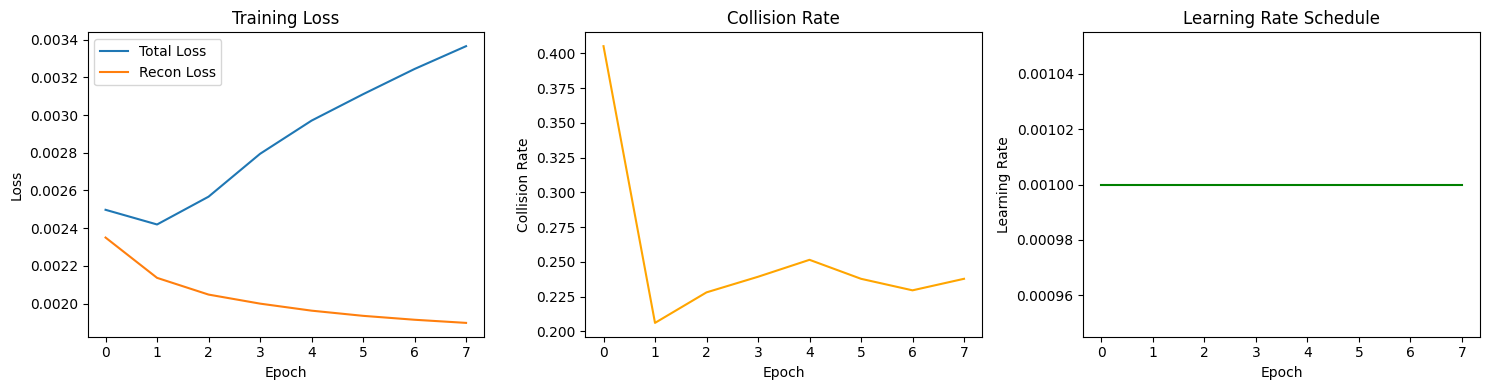

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(rq_vae.history_["loss"], label="Total Loss")
axes[0].plot(rq_vae.history_["recon_loss"], label="Recon Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training Loss")
axes[0].legend()

axes[1].plot(rq_vae.history_["collision_rate"], color="orange")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Collision Rate")
axes[1].set_title("Collision Rate")

axes[2].plot(rq_vae.history_["lr"], color="green")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Learning Rate")
axes[2].set_title("Learning Rate Schedule")

plt.tight_layout()
plt.show()

### Evaluate and Compare RQ-VAE vs RQ-KMeans

Let's run the same `evaluate()` function on RQ-VAE codes and compare the results.

In [15]:
# Evaluate RQ-VAE
vae_metrics = evaluate(embeddings, vae_codes, encoder=rq_vae)

# Side-by-side comparison

print('RQKMeans', kmeans_metrics)
print('RQ-VAE', vae_metrics)
# comparison = pd.DataFrame({
#     "RQ-KMeans": kmeans_metrics,
#     "RQ-VAE": vae_metrics,
# })
# print(comparison.to_string(float_format="%.4f"))



RQKMeans {'n_samples': 20000, 'n_unique_codes': 5473, 'collision_rate': 0.72635, 'collision_rate_per_level': [0.9995, 0.995, 0.9517, 0.72635], 'recall_at_10': 0.0796, 'ndcg_at_10': 0.0854379242257427, 'distance_correlation': 0.31419928978316564, 'code_utilization_per_level': [1.0, 1.0, 1.0, 1.0], 'code_entropy_per_level': [2.244349691299627, 2.2468010179927598, 2.2757617431202664, 2.2655703070137037], 'quantization_mse': 0.0019165873527526855}
RQ-VAE {'n_samples': 20000, 'n_unique_codes': 6181, 'collision_rate': 0.69095, 'collision_rate_per_level': [0.9995, 0.995, 0.95095, 0.69095], 'recall_at_10': 0.0381, 'ndcg_at_10': 0.040671002731363384, 'distance_correlation': 0.28073475960177563, 'code_utilization_per_level': [1.0, 1.0, 1.0, 1.0], 'code_entropy_per_level': [2.274496530171006, 2.2875435170289595, 2.2941542082025204, 2.2730988184144585], 'quantization_mse': 0.0020755711011588573}


In [16]:
# RQ-VAE reconstruction
vae_reconstructed = rq_vae.decode(vae_codes)
vae_mse = np.mean((embeddings - vae_reconstructed) ** 2)
print(f"\nRQ-VAE reconstruction MSE: {vae_mse:.6f}")
print(f"RQ-KMeans reconstruction MSE: {kmeans_metrics.get('quantization_mse', 'N/A'):.6f}")


RQ-VAE reconstruction MSE: 0.002076
RQ-KMeans reconstruction MSE: 0.001917


## 5. SinkhornResolver (Semantically-Aware Uniqueness)

Instead of appending numeric suffixes, the `SinkhornResolver` re-encodes colliding items using the Sinkhorn-Knopp balanced assignment algorithm on the last VQ layer. This produces unique IDs that are still **semantically meaningful**, rather than arbitrary suffixes.

It requires an `RQVAE` encoder and is used through the `SemanticIdEngine`.

In [17]:
# SinkhornResolver: re-encodes collisions via balanced assignment
sinkhorn_resolver = SinkhornResolver(
    max_iterations=10,      # max re-encoding rounds
    sk_epsilon=0.003,       # Sinkhorn temperature
    fallback_suffix=True,   # fall back to suffix for remaining collisions
)

sinkhorn_engine = SemanticIdEngine(
    encoder=rq_vae,
    unique_resolver=sinkhorn_resolver,
)

sinkhorn_ids = sinkhorn_engine.unique_ids(embeddings, device=device)

# Compare with suffix-based approach
suffix_engine = SemanticIdEngine(
    encoder=rq_vae,
    unique_resolver=UniqueIdResolver(store=InMemoryCollisionStore()),
)
suffix_ids = suffix_engine.unique_ids(embeddings, device=device)

print(f"Unique IDs (Sinkhorn): {len(set(sinkhorn_ids))}/{len(embeddings)}")
print(f"Unique IDs (Suffix):   {len(set(suffix_ids))}/{len(embeddings)}")
print(f"\nSample Sinkhorn IDs: {sinkhorn_ids[:5]}")
print(f"Sample Suffix IDs:   {suffix_ids[:5]}")

RQ-VAE encode: 100%|██████████| 79/79 [00:00<00:00, 304.81batch/s]

Unique IDs (Sinkhorn): 20000/20000
Unique IDs (Suffix):   20000/20000

Sample Sinkhorn IDs: ['1-2-9-5', '2-6-5-7', '8-5-8-3', '3-1-3-0', '8-9-9-0']
Sample Suffix IDs:   ['1-2-9-8', '2-6-5-4', '8-5-8-3', '3-1-3-5', '8-9-9-3']


## 6. Save and Load

Both individual encoders (`RQKMeans`, `RQVAE`) and the full `SemanticIdEngine` support `save()` / `load()`. This is essential for reproducibility — train once, save, then load on production without re-training.

In [18]:
import os
import shutil

# --- Save / Load a single encoder ---
rq_kmeans.save("tutorial_rqkmeans_model")
loaded_kmeans = RQKMeans.load("tutorial_rqkmeans_model")

# Verify: codes must match before and after loading
original_codes = rq_kmeans.encode(embeddings[:10], device=device)
loaded_codes = loaded_kmeans.encode(embeddings[:10], device=device)
assert np.array_equal(original_codes, loaded_codes), "Codes should match!"
print("RQKMeans save/load verified: codes match.")

# --- Save / Load the full engine (encoder + collision store) ---
engine.save("tutorial_engine")
loaded_engine = SemanticIdEngine.load("tutorial_engine", device=device)

new_ids = loaded_engine.unique_ids(embeddings[:5], device=device)
print(f"IDs from loaded engine: {new_ids}")

# Cleanup
for path in ["tutorial_rqkmeans_model", "tutorial_engine"]:
    if os.path.exists(path):
        shutil.rmtree(path)
print("Cleaned up saved artifacts.")

RQKMeans save/load verified: codes match.
IDs from loaded engine: ['6-5-4-4-2', '3-0-7-4-7', '2-1-2-4-1', '3-8-4-7-2', '0-1-9-2-1']
Cleaned up saved artifacts.


## 7. Batch Encoding for Large Datasets

For datasets that don't fit in GPU memory, use the `batch_size` parameter in `encode()` to process data in chunks.

In [19]:
# Process in batches of 2048 — useful when GPU memory is limited
batched_codes = rq_kmeans.encode(embeddings, device=device, batch_size=2048)
print(f"Batch-encoded {len(embeddings)} vectors -> codes shape: {batched_codes.shape}")

# Works the same way for RQ-VAE
vae_batched_codes = rq_vae.encode(embeddings, device=device, batch_size=1024)
print(f"VAE batch-encoded {len(embeddings)} vectors -> codes shape: {vae_batched_codes.shape}")

# Verify batch encoding produces identical results
assert np.array_equal(codes, batched_codes), "Batch encoding should match!"
print("Batch encoding verified: results match non-batched encoding.")

RQ-KMeans encode (mps): 100%|██████████| 10/10 [00:00<00:00, 97.52batch/s]


Batch-encoded 20000 vectors -> codes shape: (20000, 4)


RQ-VAE encode: 100%|██████████| 20/20 [00:00<00:00, 102.92batch/s]

VAE batch-encoded 20000 vectors -> codes shape: (20000, 4)
Batch encoding verified: results match non-batched encoding.


## Conclusion

You have successfully:
1.  Generated embeddings for text data.
2.  Clustered them into **Semantic IDs** using **RQ-KMeans**.
3.  Used the **token format** for LLM-friendly IDs.
4.  **Evaluated** ID quality with built-in metrics (collision rate, recall@K, distance correlation, MSE).
5.  **Decoded** codes back to approximate vectors to measure reconstruction quality.
6.  Tried **balanced clustering** with constrained K-Means for even code distribution.
7.  Ensured every ID is unique using the **SemanticIdEngine** with `UniqueIdResolver`.
8.  Trained an **RQ-VAE** and monitored training with `history_`.
9.  Used **SinkhornResolver** for semantically-aware collision resolution.
10. **Saved and loaded** models and engines for reproducibility.
11. Used **batch encoding** for memory-efficient processing.

Happy clustering! 🌟